In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from collections import defaultdict
from itertools import count

import numpy as np


import matplotlib.pyplot as plt
import plotly.offline as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import networkx as nx

In [3]:
file = "/home/ubuntu/data/tmp/karate/zkcc-77/karate_edges_78.txt"

In [19]:

def create_adjacency_matrix(file):
    node_neighbors = defaultdict(list)

    with open(file, "r") as fin:
        for line in fin:
            node_1, node_2 = line.strip().split('\t')
            node_1 = int(node_1)-1 #offset to make the integers start from zero
            node_2 = int(node_2)-1
            node_neighbors[node_1].append(node_2)

    number_of_nodes = len(node_neighbors)
    A = np.zeros((number_of_nodes, number_of_nodes))

    for node, neighbors in node_neighbors.items():
        for neighbor in neighbors:
            A[node, neighbor] = 1

    return A

def compute_modularity(A, communities, m):
    nrows, ncols = A.shape
    assert nrows == ncols
    nvertices = nrows

    modularity = 0.0
    for vertexi in range(nvertices):
        for vertexj in range(nvertices):
            ki = np.sum(A[vertexi,:])
            kj = np.sum(A[vertexj,:])
            if communities[vertexi] == communities[vertexj]:
                modularity += A[vertexi, vertexj] - (ki*kj)/(2*m)

    return modularity/(2*m)
    
def modularity_difference(A, communities, m, modularity, vertex, community):
    #save community of node
    original_community = communities[vertex]
    #change community
    communities[vertex] = community
    #compute new modularity
    new_modularity = compute_modularity(A, communities, m)
    #print(f"{nodei}, {communityi}, {self.modularity}, {new_modularity}")
    modularity_difference = new_modularity-modularity
    #restore community
    communities[vertex] = original_community
    return modularity_difference

def find_best_community(A, communities, m, modularity, vertex):
    unique_communities = np.unique(communities)
    max_modularity_difference = 0
    best_community = communities[vertex]
    for community in unique_communities:
        modularity_diff = modularity_difference(A, communities, m, modularity, vertex, community)
        print(f"modularity difference when moving {vertex} to community {community}: {modularity_diff}")
        if modularity_diff > max_modularity_difference:
            max_modularity_difference = modularity_diff
            best_community = community
    return best_community, max_modularity_difference

def reset_communities(communities):
    """
    reset the community vector so that the communities  start from zero
    
    Example:
    --------
    communities = [17,17,3,17,3,1,1,1,3,17]
    reset_communities(communities) == [0,0,1,0,1,2,2,2,1,0]
    """
    counter = count()
    community_mapper = defaultdict(lambda: next(counter))
    reset_communities = np.zeros((len(communities),), dtype=int)
    for vertex, community in enumerate(communities):
        reset_communities[vertex] = community_mapper[community]
    return reset_communities

def local_search(A, communities, m, modularity, seed=11):
    nvertices = len(communities)
    if seed>0:
        vertex_order = np.random.RandomState(seed=seed).permutation(nvertices)
    else:
        vertex_order = range(nvertices)

    is_modularity_increasing = True
    while is_modularity_increasing:
        is_modularity_increasing = False
        for vertex in vertex_order:
            best_community, modularity_difference = find_best_community(A, communities, m, modularity, vertex)
            if modularity_difference > 0:
                communities[vertex] = best_community
                modularity += modularity_difference
                print(f"moving node {vertex} to community {best_community}, modularity diff {modularity_difference}, new modularity {modularity}")
                #print("verification modularity {}".format(self.compute_modularity()))
                is_modularity_increasing = True

    communities = reset_communities(communities)

    print(f"Finished phase1, new modularity: {modularity}")

    return communities, modularity

def reduce_network(A, communities):
    #assumes communities starting from zero increasing by one
    unique_communities = np.unique(communities)
    n_communities = len(unique_communities)
    reduced_A = np.zeros((n_communities, n_communities))

    for communityi in unique_communities:
        for communityj in unique_communities:
            vertices_i = np.argwhere(communities == communityi).flatten()
            vertices_j = np.argwhere(communities == communityj).flatten()
            sub_A = A[vertices_i,:]
            sub_A = sub_A[:,vertices_j]
            reduced_A[communityi, communityj] = np.sum(np.sum(sub_A))

    print(f"Finished phase2, number of nodes/communities: {n_communities}")
    print(reduced_A)
    communities = np.array([i for i in range(reduced_A.shape[0])], dtype=int)
    
    return reduced_A, communities

def traceback_communities(reduced_communities, communities):
    #assumes community i after local search is also reduced to the i-th node
    new_communities = np.zeros((len(communities,)),dtype=int)
    for vertex, community in enumerate(communities):
        new_communities[vertex] = reduced_communities[community]
    return new_communities

def detect_communities(A, communities, community_hierarchy=[]):
    m = 0.5*np.sum(np.sum(A))
    modularity = compute_modularity(A, communities, m)

    local_communities, modularity = local_search(A, communities, m, modularity)
    community_hierarchy.append(local_communities)
    
    iteration = 1
    while True:
        A, communities = reduce_network(A, local_communities)
        print(f"Finished iteration {iteration}")

        local_communities, modularity = local_search(A, communities, m, modularity)

        expanded_communities = traceback_communities(local_communities, community_hierarchy[-1])

        if np.all(community_hierarchy[-1] == expanded_communities):
            print("communities stayed the same, stopping algorithm")
            break
            
        community_hierarchy.append(expanded_communities)

        iteration += 1

    return community_hierarchy


def detect_communities_recursive(A, communities):
    m = 0.5*np.sum(np.sum(A))
    modularity = compute_modularity(A, communities, m)

    local_communities, modularity = local_search(A, communities, m, modularity)

    
    if len(np.unique(local_communities)) < len(communities):
        reduced_A, reduced_communities = reduce_network(A, local_communities)
        reduced_communities = detect_communities_recursive(reduced_A, reduced_communities)
        expanded_communities = traceback_communities(reduced_communities, local_communities)
        #print(local_communities)
        #print(reduced_communities)
        #print(expanded_communities)
        return expanded_communities
    else:
        return communities
        

In [156]:
A = create_adjacency_matrix(file)
communities = np.array([i for i in range(A.shape[0])], dtype=int)
hierarchy = detect_communities(A, communities)

Finished phase1, new modularity: 0.38453320184089396
Finished phase2, number of nodes/communities: 6
Finished iteration 1
Finished phase1, new modularity: 0.4151051939513478
Finished phase2, number of nodes/communities: 4
Finished iteration 2
Finished phase1, new modularity: 0.4151051939513478
communities stayed the same, stopping algorithm


In [162]:
A = create_adjacency_matrix(file)
communities = np.array([i for i in range(A.shape[0])], dtype=int)
hierarchy = detect_communities_recursive(A, communities)
hierarchy

Finished phase1, new modularity: 0.38453320184089396
Finished phase2, number of nodes/communities: 6
Finished phase1, new modularity: 0.4151051939513478
Finished phase2, number of nodes/communities: 4
Finished phase1, new modularity: 0.4151051939513478
[0 1 1 2 2 3]
[0 1 2 3]
[0 1 1 2 2 3]
[0 0 0 0 1 2 2 0 3 4 1 0 0 0 4 4 2 0 4 0 4 0 4 4 5 5 4 4 5 4 3 5 4 4]
[0 1 1 2 2 3]
[0 0 0 0 1 1 1 0 2 2 1 0 0 0 2 2 1 0 2 0 2 0 2 2 3 3 2 2 3 2 2 3 2 2]


array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
       2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2])

In [5]:
def create_graph(A, communities):
    G=nx.Graph()
    
    for nodei in range(A.shape[0]):
        d = {"community": communities[nodei]}
        G.add_node(nodei+1, **d)
    
    for i, j in zip(*A.nonzero()):
        if communities[i] == communities[j]:
            weight = 100
        else:
            weight = 1
        G.add_edge(i+1, j+1, weight=weight)
        
    return G

In [6]:
def plot_graph(G, pos=None):
    plt.figure(figsize=(30,15))  
    
    node_communities = [d["community"] for _, d in G.nodes(data=True)]
    
    if pos==None:
        pos = nx.spring_layout(G, scale=30)  # positions for all nodes
    
    nx.draw_networkx_nodes(G, pos, node_color=node_communities)
    nx.draw_networkx_edges(G, pos)

    nx.draw_networkx_labels(G, pos, font_size=30, font_family='sans-serif')

    plt.axis('off')
    plt.show()
    
    return pos

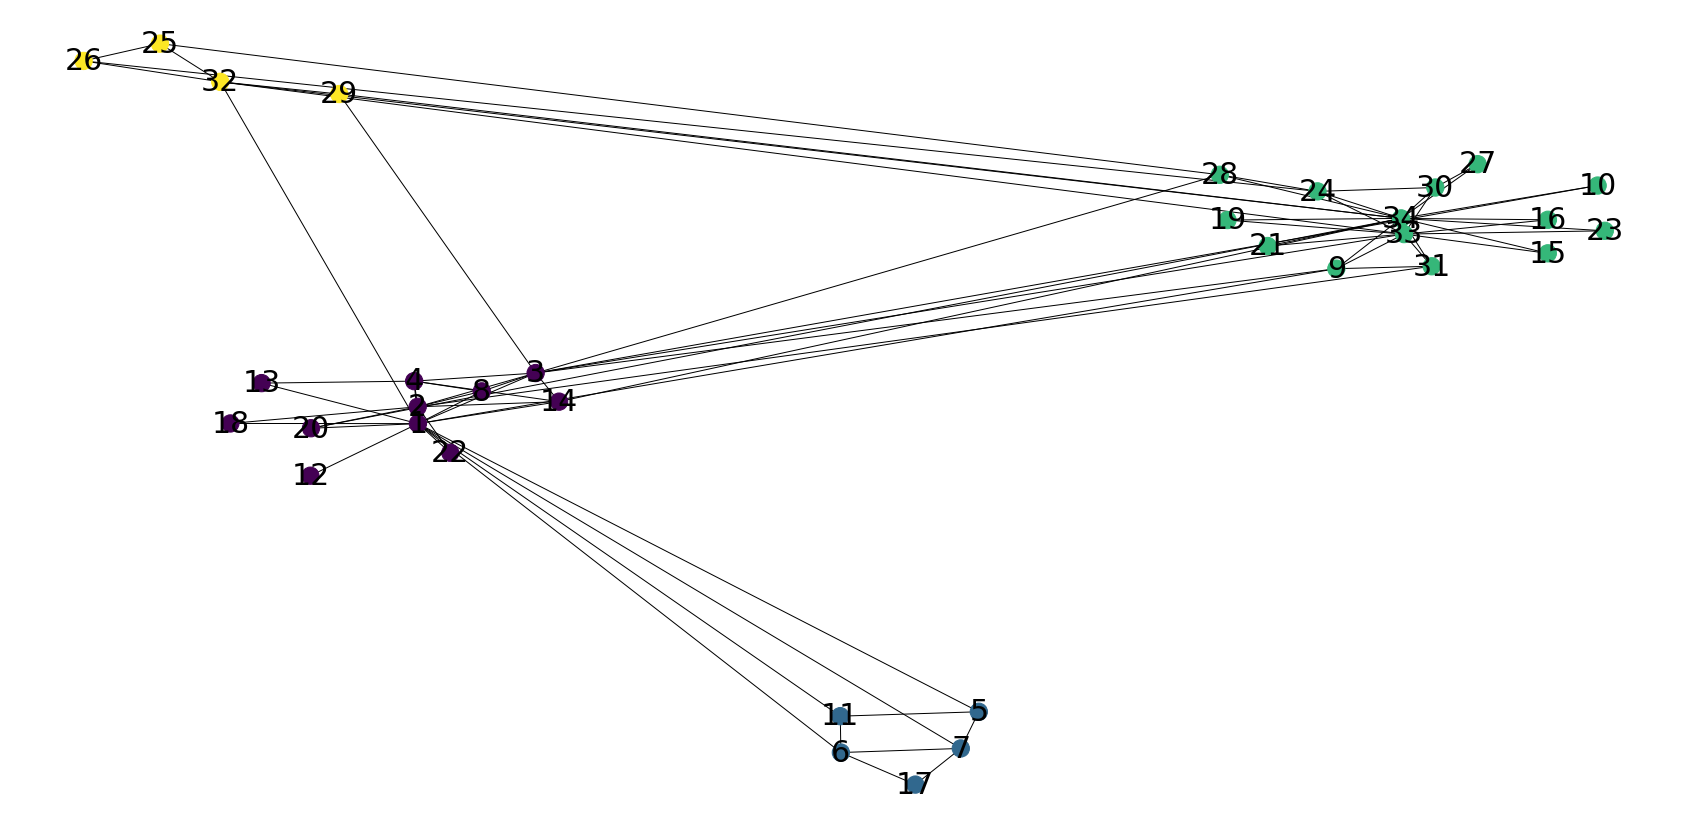

{1: array([-7.06544658, -5.58528026]),
 2: array([-7.06897434, -4.44777189]),
 3: array([-5.22144236, -2.16520191]),
 4: array([-7.1240659 , -2.71133526]),
 5: array([  1.72052993, -25.07445113]),
 6: array([ -0.44045642, -27.83267375]),
 7: array([  1.43817654, -27.55471682]),
 8: array([-6.06578815, -3.40261429]),
 9: array([7.32058012, 4.89491961]),
 10: array([11.41314491, 10.51799431]),
 11: array([ -0.44942594, -25.37218114]),
 12: array([-8.7503614 , -9.10834775]),
 13: array([-9.51386126, -2.84582092]),
 14: array([-4.85465913, -4.09893116]),
 15: array([10.63261282,  5.93325517]),
 16: array([10.63422519,  8.20253506]),
 17: array([  0.72620279, -30.        ]),
 18: array([-10.00313903,  -5.57424915]),
 19: array([5.61547341, 8.18285289]),
 20: array([-8.74010984, -5.89707618]),
 21: array([6.24534396, 6.42780328]),
 22: array([-6.55860617, -7.55709493]),
 23: array([11.52512689,  7.45620469]),
 24: array([ 7.02487209, 10.12400076]),
 25: array([-11.10652304,  20.11754902]),
 

In [163]:
com = np.array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
       2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2])
G = create_graph(A, com)
plot_graph(G)

[[0 1 1 0 0 0]
 [1 0 1 0 1 0]
 [1 1 0 0 0 0]
 [0 0 0 0 1 1]
 [0 1 0 1 0 1]
 [0 0 0 1 1 0]]
7.0
-0.17346938775510204
7.93016446160826e-18
0.35714285714285715
modularity difference when moving 4 to community 0: -0.061224489795918324
modularity difference when moving 4 to community 1: 0.05102040816326529
modularity difference when moving 4 to community 2: -0.06122448979591835
modularity difference when moving 4 to community 3: 0.0816326530612245
modularity difference when moving 4 to community 4: 0.0
modularity difference when moving 4 to community 5: 0.0816326530612245
moving node 4 to community 3, modularity diff 0.0816326530612245, new modularity -0.09183673469387754
modularity difference when moving 2 to community 0: 0.1020408163265306
modularity difference when moving 2 to community 1: 0.08163265306122447
modularity difference when moving 2 to community 2: 0.0
modularity difference when moving 2 to community 3: -0.10204081632653064
modularity difference when moving 2 to community 5: 

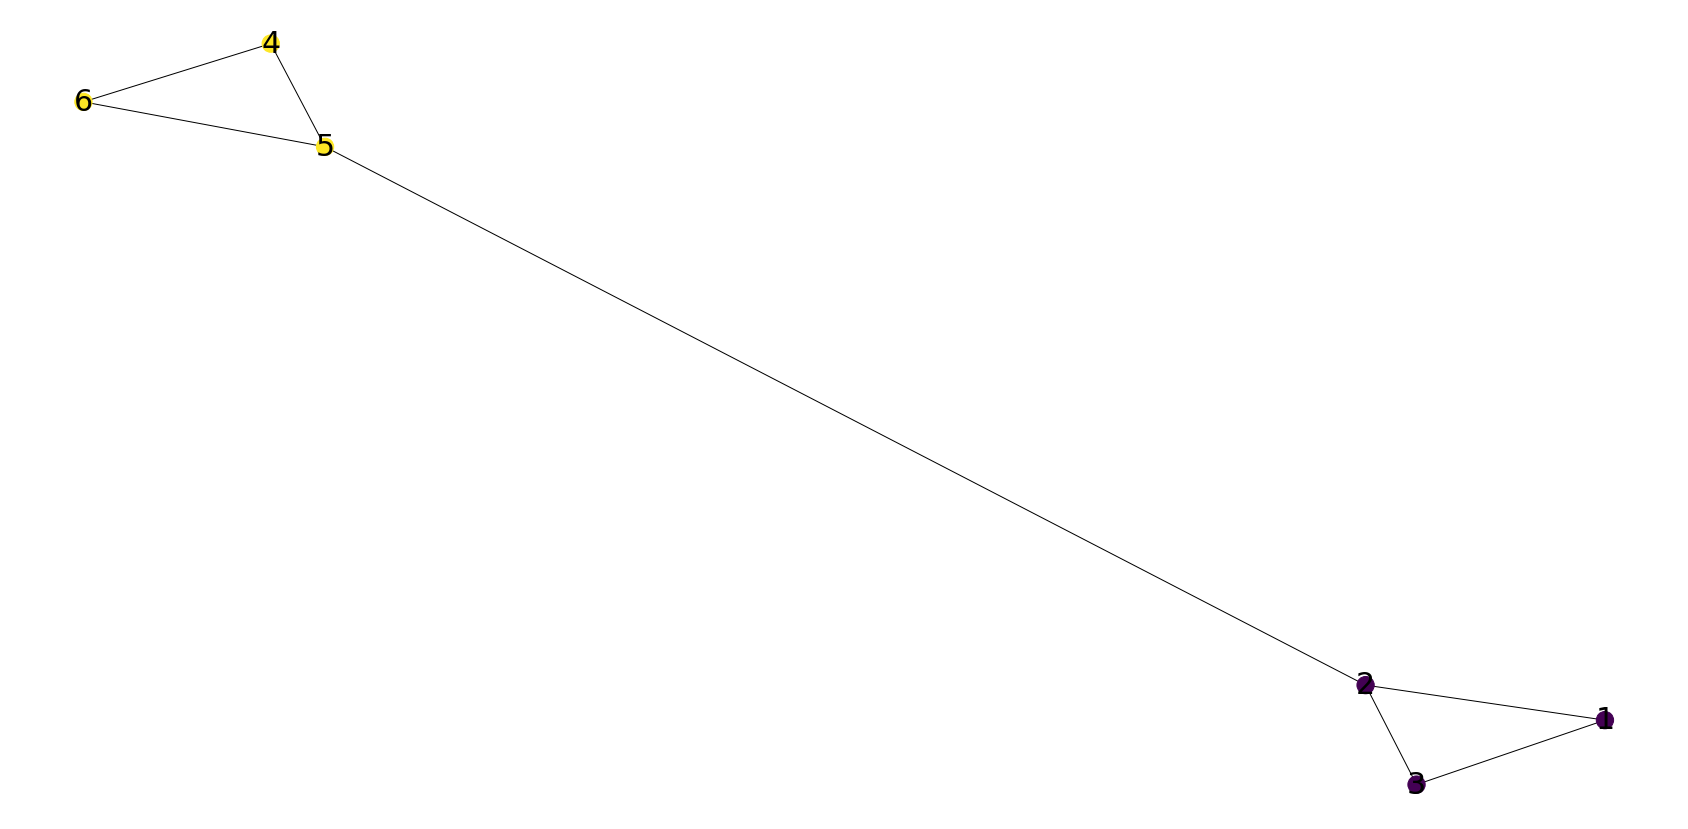

{1: array([ 24.35813346, -24.78654469]),
 2: array([ 16.69221773, -21.95427501]),
 3: array([ 18.32388434, -30.        ]),
 4: array([-18.37177331,  29.93443476]),
 5: array([-16.63251858,  21.58501561]),
 6: array([-24.36994364,  25.22136932])}

In [20]:
A = np.array([
    [0,1,1,0,0,0],[1,0,1,0,1,0],[1,1,0,0,0,0],
    [0,0,0,0,1,1],[0,1,0,1,0,1],[0,0,0,1,1,0]])
print(A)

m = 0.5*A.sum().sum()
print(m)

communities = np.array([i for i in range(A.shape[0])], dtype=int)
modularity = compute_modularity(A, communities, m)
print(modularity)

communities = np.zeros((A.shape[0],))
modularity = compute_modularity(A, communities, m)
print(modularity)

communities = np.array([0,0,0,1,1,1], dtype=int)
modularity = compute_modularity(A, communities, m)
print(modularity)

communities = np.array([i for i in range(A.shape[0])], dtype=int)
hierarchy = detect_communities_recursive(A, communities)
print(hierarchy)
G = create_graph(A, hierarchy)
plot_graph(G)

moving node 2 to community 0, modularity diff 0.04166666666666666, new modularity -0.20833333333333334
moving node 3 to community 0, modularity diff 0.08333333333333334, new modularity -0.125
moving node 1 to community 0, modularity diff 0.125, new modularity 0.0
Finished phase1, new modularity: 0.0
Finished phase2, number of nodes/communities: 1
Finished phase1, new modularity: 0.0
[0 0 0 0]


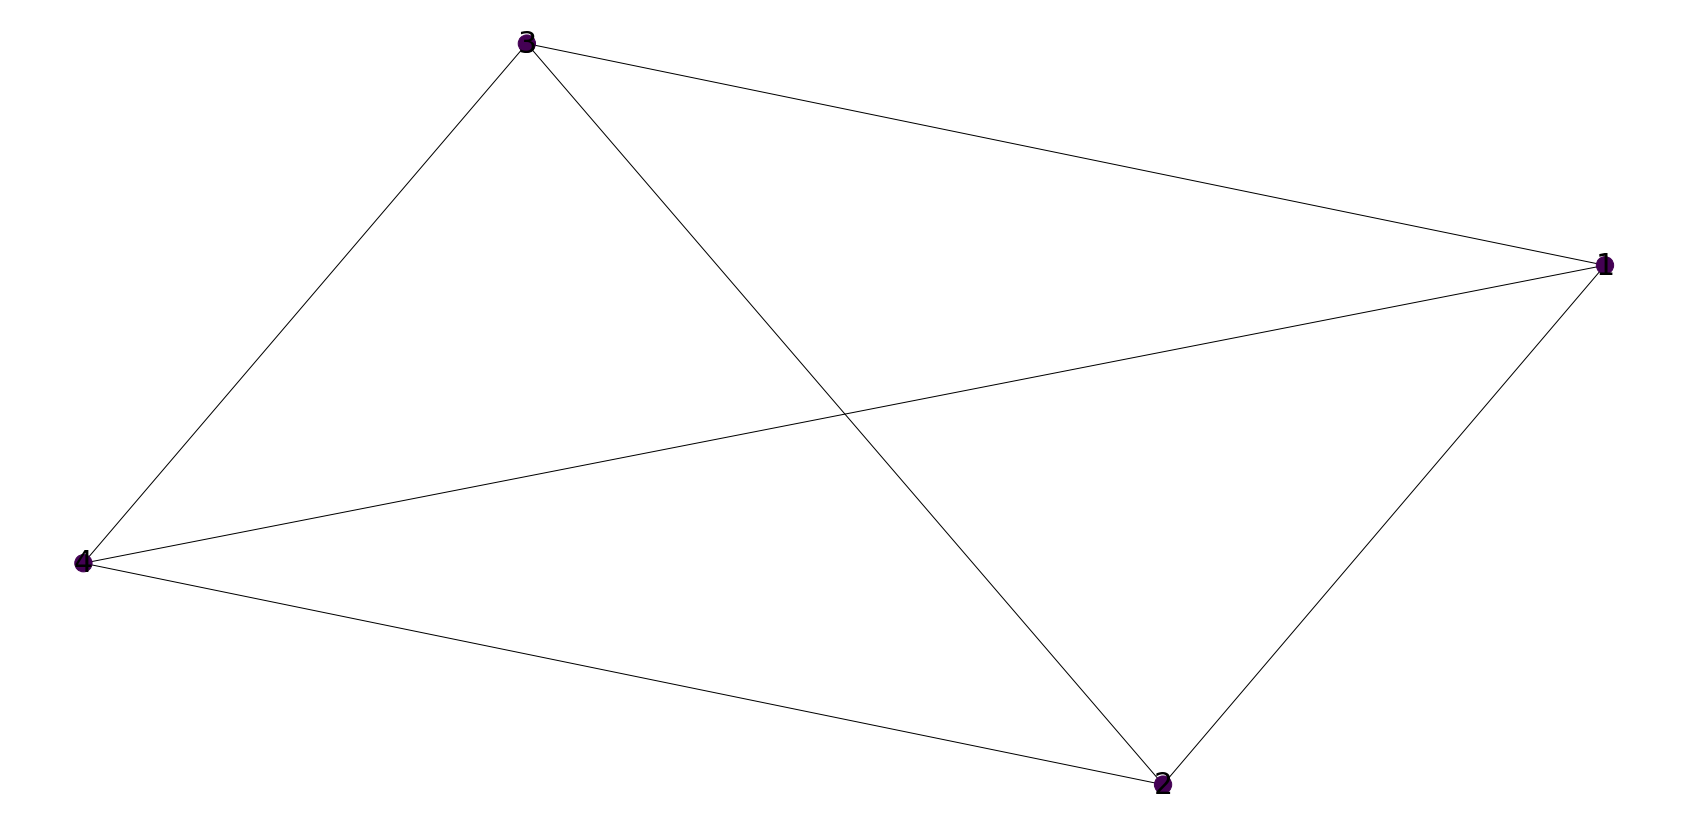

{1: array([29.39585864, 12.05168141]),
 2: array([ 12.31152126, -29.98802036]),
 3: array([-12.28230115,  30.        ]),
 4: array([-29.42507876, -12.06366105])}

In [14]:
A = np.array([[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0]])

communities = np.array([i for i in range(A.shape[0])], dtype=int)
hierarchy = detect_communities_recursive(A, communities)
print(hierarchy)
G = create_graph(A, hierarchy)
plot_graph(G)